# Kristijono Donelaičio 'Metų' hegzametras

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tabulate
from  matplotlib.ticker import FuncFormatter

sns.set_style("whitegrid")
pd.set_option("styler.format.decimal", ",")
pd.set_option("styler.format.precision", 2)
pd.set_option("styler.format.na_rep", "–")

def write_table(df, the_name):
    with open(f"table-{the_name}.tex", "w") as f:
        f.write(df.style.to_latex(hrules=True, sparse_index=False))

In [2]:
all_caesuras = ["3h", "5h", "ktt", "7h", "pqt", "bd"]
df = pd.read_csv("metai/metai-scansion.csv")
print(len(df))

2968


In [3]:
incorrect_lines = df[df.isnull()["scansion"]]
df = df.dropna()
print(len(incorrect_lines))
incorrect_lines

5


,book,verse,text,words,syllables,scansion,3h,5h,ktt,7h,pqt,bd,metre,metreConflict,stress,stressConflict,weight,weightConflict
189,1,190,"sykeis vargstantiems, néy kôks gĕrădėjas,",5,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,×××××××⏑⏑××,NaN,×××××––××××,NaN,⏑––––––⏑⏑––,NaN
477,1,478,"taigĭ nŭtvérkim jau kiekviens săvŏ iáutį,",6,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,×⏑⏑×××××⏑⏑××,NaN,××⏑–⏑×××××–⏑,NaN,–⏑⏑–––––⏑⏑––,NaN
682,2,23,bet sù koynù kasdien dangaus ĭssĭgâsta!,6,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,××××××××⏑⏑××,NaN,×–⏑–××××⏑⏑–⏑,NaN,–⏑–⏑⏑––––⏑–⏑,NaN
1807,3,434,"mùms kasdien ir taìp dosnaý dŏvănója,",6,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,×××××××⏑⏑××,NaN,–×××–⏑–⏑⏑–⏑,NaN,–⏑–––⏑–⏑⏑–⏑,NaN
2523,4,238,"taìp kad jós smarkùms, tamsój păsĭkėlęs,",6,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,×××××××⏑⏑××,NaN,–×–⏑–⏑–××××,NaN,–––––––⏑⏑––,NaN


In [4]:
ambiguous = df["scansion"].str.contains(r'\|')
ambiguous_lines = df[ambiguous]
df = df[~ambiguous]
print(len(ambiguous_lines))
print(len(df))

11
2952


In [5]:
# convert data types
df["scansion"] = pd.Categorical(df["scansion"], sorted(df["scansion"].drop_duplicates().values, key=lambda x: x[::-1]))

for caesura in all_caesuras:
    df[caesura] = df[caesura].map({"True": True, "False": False})

for column in ["stressConflict", "metreConflict", "weightConflict", "syllables", "words"]:
    df[column] = df[column].astype(int)

In [6]:
len(df)

2952

## How well does the analysis match the syllables?

In [7]:
pd.set_option("styler.format.precision", 0)
conflicts = df[["metreConflict", "stressConflict", "weightConflict"]].apply(pd.Series.value_counts)
conflicts.index = conflicts.index.rename("Anzahl Konflikte")
write_table(conflicts, "conflicts")
pd.set_option("styler.format.precision", 2)
conflicts

,metreConflict,stressConflict,weightConflict
Anzahl Konflikte,,,
0,2920.0,2220.0,853
1,32.0,668.0,1085
2,NaN,56.0,701
3,NaN,8.0,238
4,NaN,NaN,60
5,NaN,NaN,14
6,NaN,NaN,1


In [8]:
# df["weightConflict"].astype(int).value_counts(
df[df["weightConflict"] >= 5]

,book,verse,text,words,syllables,scansion,3h,5h,ktt,7h,pqt,bd,metre,metreConflict,stress,stressConflict,weight,weightConflict
53,1,54,ogĭ trŏbà vissà vissùr iškrypŭsĭ ròdės;,6,14,DSSSDS,True,True,False,True,False,False,×⏑⏑×××××××⏑⏑××,0,××⏑–⏑–⏑–××××–⏑,0,⏑⏑⏑⏑–⏑––⏑⏑⏑⏑⏑–,5
193,1,194,àr sù próvita pučkà tikt mùšă tĭkt mùša-,8,13,SSSSDS,False,True,False,True,False,True,×××××××××⏑⏑××,0,–––⏑⏑⏑–×–⏑×–⏑,1,–⏑–⏑⏑–⏑–⏑⏑–⏑⏑,5
231,1,232,bèt dâr tai nĕ gănà; jis viss pĭnnį̆gu ...,9,14,SDSDSS,True,True,False,True,False,False,×××⏑⏑×××⏑⏑××××,0,––××⏑–××××××××,0,–––⏑⏑⏑––––⏑–⏑–,5
250,1,251,"mislija, kàd kóžnas pônas puikey issĭrėdęs",6,14,SSSDDS,True,False,False,False,True,False,×××××××××××⏑××,0,×××––⏑–⏑××××××,0,⏑⏑⏑––––––––⏑––,5
266,1,267,o momà sù̆ răžù sùpykus mùšĕ pĕr ausį.,8,14,SDSSDS,True,True,False,False,False,True,×××⏑⏑×××××⏑⏑××,0,×⏑––⏑––⏑⏑–⏑×××,2,⏑⏑⏑⏑⏑⏑⏑⏑–⏑⏑–––,6
363,1,364,tù sù sàvŏ iĕvà sodè pavásărĭ švęsd...,7,14,SDSSDS,False,True,False,True,False,False,×××⏑⏑×××××⏑⏑××,0,–––⏑⏑–⏑–⏑–⏑⏑××,0,⏑⏑⏑⏑–⏑⏑⏑⏑–⏑⏑––,5
378,1,379,tù sù sàvŏ iĕvà jùk dâr nè bùvŏtă ...,9,14,SDSSDS,False,True,False,True,False,True,×××⏑⏑×××××⏑⏑××,0,–––⏑⏑–––––⏑⏑××,0,⏑⏑⏑⏑–⏑––⏑⏑⏑⏑––,5
1466,3,93,ypăčĕy ìš visù enskýs săvŏ šìmĕlį̆ p...,7,15,DSSDDS,True,True,False,True,False,True,×⏑⏑×××××⏑⏑×⏑⏑××,0,×××–⏑–⏑–××–⏑⏑–⏑,0,⏑⏑––⏑⏑––⏑⏑⏑⏑–––,5
1518,3,145,àlĕ žą̆sú bei vìštu vós vienà păsĭlìko.,7,14,DSSSDS,True,False,False,True,False,False,×⏑⏑×××××××⏑⏑××,0,–⏑⏑–×–⏑–⏑–⏑⏑–⏑,0,⏑⏑–––⏑⏑––⏑⏑⏑⏑⏑,5
1547,3,174,"nės jie mìslyjo, kad búrs, pas krìzą̆ sė...",8,13,SSSSDS,False,True,False,True,False,True,×××××××××⏑⏑××,0,××–⏑⏑×–×–⏑×××,1,––⏑⏑⏑–––⏑––––,5


In [26]:
df[(df["stressConflict"] >= 3) & (df["weightConflict"] >= 3)]

,book,verse,text,words,syllables,scansion,3h,5h,ktt,7h,pqt,bd,metre,metreConflict,stress,stressConflict,weight,weightConflict
133,1,134,"tù nè lúbiji pyragû neigĭ răgaišiû,",6,13,SSSSDS,0,1,0,0,0,1,×××××××××⏑⏑××,0,–––⏑⏑⏑⏑–××⏑⏑–,3,⏑⏑–⏑⏑⏑⏑––⏑⏑––,3


## Amount of syllables

In [31]:
syllables_per_word = df["syllables"].sum() / df.words.sum()
syllables_per_word

1.9895583533173462

In [48]:
syllables_per_verse = df["syllables"].mean()
print(df.syllables.std())
syllables_per_verse

0.6455318125732312


13.490176151761517

In [37]:
# syll / words
syls_per_words = (df.groupby("book")["syllables"].sum() / df.groupby("book")["words"].sum()).rename("Silben / Wort")
average_sylls = df.groupby("book")["syllables"].mean().rename("μ Silben")
stddev_sylls = df.groupby("book")["syllables"].std().rename("σ Silben")
df_syllables = pd.concat([syls_per_words, average_sylls, stddev_sylls], axis=1)
df_syllables.index = df_syllables.index.rename("Buch")
write_table(df_syllables, "syllables")
df_syllables

,Silben / Wort,μ Silben,σ Silben
Buch,,,
1,1.965188,13.551988,0.688711
2,1.973744,13.484463,0.645766
3,2.025509,13.452145,0.609369
4,1.982945,13.487518,0.646420


In [43]:
df_syllables["Silben / Wort"].std()

0.02677551584814646

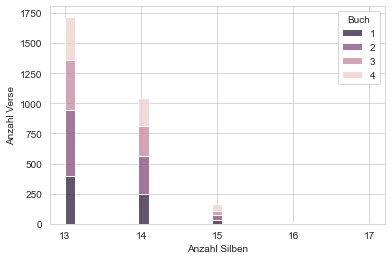

In [11]:
# syllable count histogram
ax = sns.histplot(x="syllables", data=df, hue="book", multiple="stack")
ax.set(xlabel='Anzahl Silben', ylabel='Anzahl Verse')
ax.legend(title="Buch", labels=[1,2,3,4])
ax.set_xticks(sorted(list(df["syllables"].drop_duplicates().values)))
plt.savefig("figure-syllable-count-histogram.svg")

In [51]:
df_syllables_count = pd.DataFrame(df["syllables"].rename("Anzahl Verse").value_counts())
df_syllables_count.index = df_syllables_count.index.rename("Silbenzahl")
df_syllables_count["Anteil Verse/\\%"] = 100 * df_syllables_count["Anzahl Verse"] / len(df)
write_table(df_syllables_count, "syllable-count")
df_syllables_count

,Anzahl Verse,Anteil Verse/\%
Silbenzahl,,
13,1719,58.231707
14,1045,35.399729
15,168,5.691057
16,14,0.474255
17,6,0.203252


## Scansion

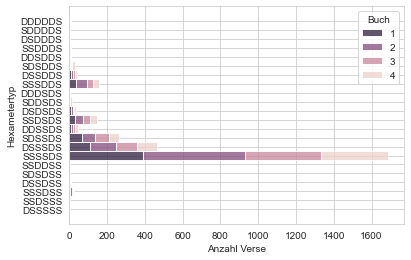

In [13]:
ax = sns.histplot(y="scansion", data=df, hue="book", multiple="stack")
ax.set(ylabel='Hexametertyp', xlabel='Anzahl Verse')
ax.legend(title="Buch", labels=[1,2,3,4])
plt.savefig("figure-scansion-histogram.svg")

In [75]:
pd.set_option("styler.format.precision", 2)
spondees_dactyls = pd.DataFrame()
spondees_dactyls["Buch"] = df["book"]
spondees_dactyls["S"] = df["scansion"].str.count("S")
spondees_dactyls["D"] = df["scansion"].str.count("D")
print(spondees_dactyls.sum(), spondees_dactyls.sum().D / (spondees_dactyls.sum().D + spondees_dactyls.sum().S))
df_s_d = spondees_dactyls.groupby("Buch").sum()
df_s_d["Anteil D/\\%"] = df_s_d["D"] / (df_s_d["S"] + df_s_d["D"])
write_table(df_s_d, "dactyls-spondees")
df_s_d

Buch     7521
S       13313
D        4399
dtype: int64 0.24836269196025293


,S,D,Anteil D/\%
Buch,,,
1,2909,1015,0.258665
2,3197,1051,0.247411
3,4134,1320,0.242024
4,3073,1013,0.247920


In [14]:
df_scansion = pd.DataFrame(df["scansion"].rename("Anzahl Verse").value_counts())
df_scansion["Anteil Verse/\\%"] = 100 * df_scansion["Anzahl Verse"] / len(df)
df_scansion.index = df_scansion.index.rename("Hexametertyp")
write_table(df_scansion, "scansion-types")
df_scansion[0:10]

,Anzahl Verse,Anteil Verse/\%
Hexametertyp,,
SSSSDS,1689,57.215447
DSSSDS,465,15.752033
SDSSDS,263,8.909214
SSSDDS,157,5.318428
SSDSDS,144,4.878049
DDSSDS,47,1.592141
DSSDDS,39,1.321138
DSDSDS,33,1.117886
SDSDDS,27,0.914634


In [15]:
pd.crosstab(df['scansion'].rename("Hexametertyp"), df['syllables'].rename("Silbenzahl"))

Silbenzahl,13,14,15,16,17
Hexametertyp,,,,,
DDDDDS,0,0,0,0,6
SDDDDS,0,0,0,1,0
DSDDDS,0,0,0,5,0
SSDDDS,0,0,10,0,0
DDSDDS,0,0,0,7,0
SDSDDS,0,0,27,0,0
DSSDDS,0,0,39,0,0
SSSDDS,0,157,0,0,0
DDDSDS,0,0,0,1,0


In [16]:
strange_verses = df[df["scansion"].str.endswith("SSS")][["book", "verse", "text", "scansion"]]
write_table(strange_verses, "strange-verses")
strange_verses

,book,verse,text,scansion
1087,2,428,"iómarke brangvyno stuopą vìssą nŭrijęs,",DSSSSS
1118,2,459,"ik paskiáus iš pápykio beržinnį păgávęs,",SSDSSS
1693,3,320,"àr nĕsĭbìjotės užsprìngt, kad kábĭăr ...",DSSSSS
2418,4,133,ìr kitiems baudžáuninkams tikt gėdą pădáro.,SSDSSS


## Caesurae

### Caesuras per book

In [17]:
caesura_rows = []
for index, row in df.iterrows():
    for caesura in all_caesuras:
        if row[caesura] == True:
            caesura_rows.append([row["book"], row["verse"], caesura])
caesura_df = pd.DataFrame(caesura_rows, columns=["book", "verse", "caesura"])
caesura_df["caesura"] = pd.Categorical(caesura_df["caesura"], all_caesuras)

In [18]:
caesura_per_book = pd.crosstab(caesura_df["book"].rename("Buch"), caesura_df["caesura"].rename("Einschnitt"))
write_table(caesura_per_book, "caesura-per-book")
caesura_per_book

Einschnitt,3h,5h,ktt,7h,pqt,bd
Buch,,,,,,
1,380,492,11,394,10,387
2,395,549,7,431,11,391
3,525,703,6,549,9,514
4,372,530,4,430,10,372


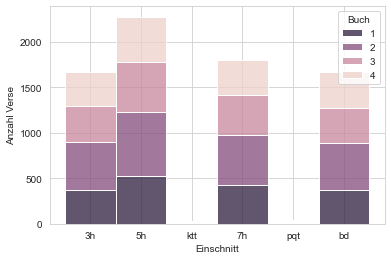

In [19]:
ax = sns.histplot(x="caesura", data=caesura_df, hue="book", multiple="stack")
ax.set(xlabel='Einschnitt', ylabel='Anzahl Verse')
ax.legend(title="Buch", labels=[1,2,3,4])
plt.savefig("figure-caesura-histogram.svg")

In [20]:
reslut = []
for s in all_caesuras:
    count = df[s].value_counts()[True]
    reslut.append([count, 100 * count / len(df)])
caesura_count = pd.DataFrame(reslut, columns=["Anzahl Verse", "Anteil/\\%"])
caesura_count.index = all_caesuras
caesura_count = caesura_count.sort_values("Anzahl Verse", ascending=False)
caesura_count.index = caesura_count.index.rename("Einschnitt")
write_table(caesura_count, "caesura-count")
caesura_count


,Anzahl Verse,Anteil/\%
Einschnitt,,
5h,2274,77.032520
7h,1804,61.111111
3h,1672,56.639566
bd,1664,56.368564
pqt,40,1.355014
ktt,28,0.948509


### Caesura-less lines

In [21]:
caesuraless = df[~df["3h"] & ~df["5h"] & ~df["ktt"] & ~df["7h"] & ~df["pqt"] & ~df["bd"]]
write_table(caesuraless, "caesuraless")
caesuraless

,book,verse,text,words,syllables,scansion,3h,5h,ktt,7h,pqt,bd,metre,metreConflict,stress,stressConflict,weight,weightConflict
1009,2,350,"taip, kàd klápai vyžu viežlibay pădărytû,",6,13,SSSSDS,False,False,False,False,False,False,×××××××××⏑⏑××,0,×––⏑×××××⏑⏑⏑–,1,––––⏑⏑–⏑–⏑⏑⏑–,2
1307,2,648,irgĭ kănápės vėjû parblôkštos svĭrĭne...,5,14,DSSSDS,False,False,False,False,False,False,×⏑⏑×××××××⏑⏑××,0,××⏑–⏑⏑–⏑–⏑××××,3,–⏑⏑–––––––⏑⏑–⏑,0
1485,3,112,"ir į sávŏ nămélį viezlibaý sŭvădìnęs,",6,14,SDSSDS,False,False,False,False,False,False,×××⏑⏑×××××⏑⏑××,0,××–⏑⏑–⏑⏑⏑–⏑⏑–⏑,1,–––⏑⏑–––⏑–⏑⏑⏑–,1
1538,3,165,"bèt, kaip pónai dáro, tranšieruot nĕmŏkė...",6,13,SSSSDS,False,False,False,False,False,False,×××××××××⏑⏑××,0,–×–⏑–⏑×××××××,0,–––––⏑–––⏑⏑––,0
2087,3,714,"bártis, ìrgĭ nĕšvánkey kóliotis ŭssĭma...",5,14,SDSSDS,False,False,False,False,False,False,×××⏑⏑×××××⏑⏑××,0,–⏑–⏑⏑–⏑–⏑⏑⏑⏑–⏑,1,–––⏑⏑––––––⏑––,1
2161,3,788,"ìr puikióku kùrpiu gėdėjos pămĭnėti,",5,13,SSSSDS,False,False,False,False,False,False,×××××××××⏑⏑××,0,–⏑–⏑–⏑×××××××,0,–––⏑–––––⏑⏑–⏑,0
2602,4,317,bèt ir dùrăką̆ pùloks pérplyšdams păgă...,6,14,SDSSDS,False,False,False,False,False,False,×××⏑⏑×××××⏑⏑××,0,–×–⏑⏑–⏑–⏑⏑⏑⏑–⏑,1,––⏑⏑–⏑––⏑–⏑⏑⏑⏑,4


### Caesura co-occurrences

In [22]:
from itertools import product
caesura_count = len(all_caesuras)
occurrences = np.zeros((caesura_count+1, caesura_count+1))
matrix = np.zeros((caesura_count))
for idx, row in df[all_caesuras].iterrows():
    for c1 in all_caesuras:
        if row[c1] and not any(row[c2] for c2 in all_caesuras if c2 != c1):
            i = all_caesuras.index(c1)
            matrix[i] += 1
    for c1, c2 in product(all_caesuras, all_caesuras):
        if c1 == c2:
            continue
        i1, i2 = all_caesuras.index(c1), all_caesuras.index(c2)
        if row[c1] and row[c2]:
            occurrences[i1, i2] += 1
occurrences[-1,:-1] = matrix
occurrences[:-1,-1] = matrix
occurrences = occurrences.astype(int)
df_occ = pd.DataFrame(occurrences, index=all_caesuras + ["keine"], columns=all_caesuras + ["keine"])

In [23]:
df_tril = df_occ.where(np.tril(np.ones(df_occ.shape), k=-1).astype(bool))
pd.set_option("styler.format.precision", 0)
write_table(df_tril, "cooccurrences")
df_occ
#df_tril.style.format(precision=0)

,3h,5h,ktt,7h,pqt,bd,keine
3h,0,1200,9,988,22,977,19
5h,1200,0,6,1217,19,1419,56
ktt,9,6,0,17,0,15,1
7h,988,1217,17,0,14,667,116
pqt,22,19,0,14,0,0,5
bd,977,1419,15,667,0,0,6
keine,19,56,1,116,5,6,0


In [24]:
df_copy = df
for caesura in all_caesuras:
    df_copy[caesura] = df_copy[caesura].map({True: "1", False: "0"})
df_caesura_combinations = pd.DataFrame(df_copy.groupby(all_caesuras).size().sort_values(ascending=False), columns=["Anzahl Verse"])
write_table(df_caesura_combinations, "caesura-combinations")
df_caesura_combinations

Anzahl Verse
3h 5h ktt 7h pqt bd              
1  1  0   0  0   1            573
0  1  0   1  0   0            388
          0  0   1            377
1  1  0   1  0   0            348
   0  0   1  0   0            260
0  1  0   1  0   1            241
1  1  0   1  0   1            225
   0  0   1  0   1            143
0  0  0   1  0   0            116
   1  0   0  0   0             56
   0  0   1  0   1             52
1  1  0   0  0   0             41
   0  0   0  0   1             32
                 0             19
             1   0             12
0  0  0   0  0   0              7
      1   0  0   1              7
   1  0   1  1   0              6
   0  1   1  0   0              6
      0   0  0   1              6
   1  0   0  1   0              5
   0  0   0  1   0              5
1  1  0   0  1   0              4
0  0  1   1  0   1              4
1  1  0   1  1   0              4
   0  1   1  0   0              2
   1  1   1  0   0              2
0  0  0   1  1   0              2
1  1  1   1  0   1              2
   0  0   1  1   0              2
0  0  1   0  0   0              1
1  0  1   0  0   1              1
                 0              1
   1  1   0  0   1              1
0  1  1   1  0   0              1